In [1]:
"""
@author Ryan Williams
     
     Notebook 7 - Model Training and Evaulation

@date June-October, 2021
"""

'\n@author Ryan Williams\n     \n     Notebook 7 - Model Training and Evaulation\n\n@date June-October, 2021\n'

# Notebook 7- Model Training and Evaulation

**Aim:** The aim of this notebook is to train and evaluate the models producded by Notebook 6.

**Summary:** 
- Import necessary packages.
- Import the models.
- Train and evaluate models.
- Look at results.

In [1]:
# Imports for random number influenced packages
import os  # For accessing environmental features
import numpy as np  # For some maths operations
import random as rn  # For random number gneration
import tensorflow as tf  # For support of deep models
from tensorflow import keras  # For deep model backend
from keras import backend as K  # To allow us to set random seed

# Set seed value for consistency 
seed_value = 1

# Set Tensorflow to run on CPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Set seed for Python environmental variables
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Set seed for numpy and random packages 
np.random.seed(seed_value)
rn.seed(seed_value)

# Set seed for Tensorflow environment 
session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1, 
        inter_op_parallelism_threads=1
)
tf.random.set_seed(seed_value)

# Set seed for Keras backend of Tensorflow 
sess = tf.compat.v1.Session(
        graph=tf.compat.v1.get_default_graph(), 
        config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

2021-12-14 20:36:49.444834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-14 20:36:49.444869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-12-14 20:38:53.699402: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-14 20:38:53.940285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-14 20:38:53.940328: W tensorflow/stream_ex

Import necessary packages.

In [2]:
# Imports
import glob  # For directory operations
import time  # For timining executions
import joblib  # For file operations 
import pickle  # For opening and saving to pickle files
import numpy as np   # For some maths operations
import pandas as pd  # For using pandas daraframe
import seaborn as sns  # For figure creation
from collections import Counter  # For array operations
import matplotlib.pyplot as plt  # For plotting figures 
# Sklearn
from sklearn.svm import SVC  # For our SVM model
from sklearn.pipeline import Pipeline  # For creating model Pipelines
from sklearn.preprocessing import StandardScaler  # For standardising data inputs to models
from sklearn.linear_model import LogisticRegression  # For our Logistic Regression model
from sklearn.metrics import precision_recall_curve, average_precision_score  # For metrics of models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, balanced_accuracy_score  # For metrics of models
# Tensorflow all for builing deep models
from keras import models
from keras.models import Sequential
from keras.layers.merge import concatenate 
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, Dropout, BatchNormalization, ReLU, Input, GlobalAveragePooling1D

In [3]:
TRUNCATE_RATIO = 0.25

# Data parsing helper functions

In [4]:
def load_dataset_into_dict(dataset='base', truncate_ratio=1): 
    dataset_dict = {}
    train = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_train.pkl'))
    test = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_test.pkl'))
    dataset_dict['train'] = train[:int((len(train))*truncate_ratio)]
    dataset_dict['test'] = test[:int((len(test))*truncate_ratio)]
    del train
    del test
    return dataset_dict

# Helper function to averages the values within a window of data, given a list of windows.
def avg_window(list_window):
    average_windows_list = []
    # Iterate through each window passed in.
    for window in (list_window):
        # Rotate the values in the 2D array so that we have lists of each feature.  
        current_window = list(zip(*window[::-1]))
        feature_list = []
        # Iterate through each feature and average them, storing the results
        for feature in (current_window):   
            feature_list.append(np.mean(feature))
        average_windows_list.append(feature_list)
    del feature_list # delete to save memory usage
    return (average_windows_list)

def load_dataset_for_conven(dataset='base', truncate_ratio=1):
    # Load in test train pkl files
    train = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_train.pkl'))
    test = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_test.pkl'))
    x_train = avg_window((train['x_window'][:int((len(train))*truncate_ratio)]).to_list())
    y_train = (train['label'][:int((len(train))*truncate_ratio)]).to_list()
    x_test = avg_window((test['x_window'][:int((len(test))*truncate_ratio)]).to_list())
    y_test = (test['label'][:int((len(test))*truncate_ratio)]).to_list()
    weight_for_0 = (1 / Counter(y_train)[0]) * (len(y_train) / 2.0)
    weight_for_1 = (1 / Counter(y_train)[1]) * (len(y_train) / 2.0)
    class_weights = {0: weight_for_0, 1: weight_for_1}

    del train
    del test

    return x_train, y_train, x_test, y_test, class_weights


def load_dataset_for_deep(dataset='base', truncate_ratio=1):
    # Load in test train pkl files
    train = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_train.pkl'))
    test = (pd.read_pickle('./sepsis-detection/data/processed/dataset_'+dataset+'_test.pkl'))
    # Extract x and y data, truncating as specified. 
    x_train = np.array((train['x_window'][:int((len(train))*truncate_ratio)]).to_list())
    y_train = np.array((train['label'][:int((len(train))*truncate_ratio)]).to_list())
    x_test = np.array((test['x_window'][:int((len(test))*truncate_ratio)]).to_list())
    y_test = np.array((test['label'][:int((len(test))*truncate_ratio)]).to_list())
    del train # delete to reduce memory load.
    del test # delete to reduce memory load.
    # Calculate class weightings using inverse distribution within training set.
    weight_for_0 = (1 / Counter(y_train)[0]) * (len(y_train) / 2.0)
    weight_for_1 = (1 / Counter(y_train)[1]) * (len(y_train) / 2.0)
    class_weights = {0: weight_for_0, 1: weight_for_1}
    # Calculate inital bias values for output layers.
    initial_bias = np.log([Counter(y_train)[1]/Counter(y_train)[0]])
    # Return
    return x_train, y_train, x_test, y_test, class_weights, initial_bias

# Import conventional models

In [5]:
# Store each of our models within a dictionary for easier access
conven_model_dict = {}

# Load in base set to be able to model our class weights on 
x_train, y_train, x_test, y_test, class_weights = load_dataset_for_conven(truncate_ratio=TRUNCATE_RATIO)
del x_train, y_train, x_test, y_test 

# SVM
# Use the same pipe design as used within Notebook 6
svm_pipe = Pipeline([('s', StandardScaler()), ('clf', SVC(class_weight=class_weights, probability=True, random_state=seed_value))])
# Import saved best hyperparameters and set them to our pipe
svm_params = joblib.load('./sepsis-detection/models/conven/SVM_model.pkl')
svm_pipe.set_params(**svm_params)
# Locally save the model pipeline in our model dictionary
conven_model_dict['SVM'] = svm_pipe

MAX_ITER = 5000
# Logisitc regression
# Use the same pipe design as used within Notebook 6
lr_pipe = Pipeline([('s', StandardScaler()), ('clf', LogisticRegression(class_weight=class_weights, random_state=seed_value, max_iter=MAX_ITER))])
# Import saved best hyperparameters and set them to our pipe
lr_params = joblib.load('./sepsis-detection/models/conven/lr_model.pkl')
lr_pipe.set_params(**lr_params)
# Locally save the model pipeline in our model dictionary
conven_model_dict['LR'] = lr_pipe

# Import deep models

Set some constants

In [5]:
BATCH_SIZE = 1024
VERBOSE = 0
TRAINING_EPHOCS = 10

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
      ]

callbacks = [
    keras.callbacks.EarlyStopping(monitor='tp', patience=20, mode='max', restore_best_weights=True)
]

Create model builder functions for the SNN's member models.

In [6]:
# Implementaion based on: https://github.com/hfawaz/ijcnn19ensemble/blob/master/src/classifiers/mlp.py
def MLP_builder(no_features, starting_bias):
	input_layer = keras.layers.Input((10,no_features))
	# flatten/reshape because when multivariate all should be on the same axis 
	input_layer_flattened = keras.layers.Flatten()(input_layer)
	layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
	layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)
	layer_2 = keras.layers.Dropout(0.2)(layer_1)
	layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)
	layer_3 = keras.layers.Dropout(0.2)(layer_2)
	layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)
	output_layer = keras.layers.Dropout(0.3)(layer_3)
	output_layer = keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(starting_bias))(output_layer)
	model = keras.models.Model(inputs=input_layer, outputs=output_layer)
	model.compile(loss='binary_crossentropy', optimizer='Adam',metrics=METRICS)
	return model

# Based on implementaion from: https://github.com/hfawaz/ijcnn19ensemble/blob/master/src/classifiers/fcn.py
def FCN_builder(no_features, starting_bias):
	input_layer = keras.layers.Input((10,no_features))
	conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same')(input_layer)
	conv1 = BatchNormalization()(conv1)
	conv1 = keras.layers.Activation(activation='relu')(conv1)
	conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same')(conv1)
	conv2 = BatchNormalization()(conv2)
	conv2 = keras.layers.Activation('relu')(conv2)
	conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same')(conv2)
	conv3 = BatchNormalization()(conv3)
	conv3 = keras.layers.Activation('relu')(conv3)
	gap_layer = GlobalAveragePooling1D()(conv3)
	output_layer = Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(starting_bias))(gap_layer)
	model = keras.models.Model(inputs=input_layer, outputs=output_layer)
	model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics=METRICS)
	return model 

Load in the optimal CNN architecture and create a model builder accordingly.

In [7]:
# Load in the optimized architecture from Notebook 6
with open('./sepsis-detection/models/deep/cnn_structure.pickle', 'rb') as handle:
    cnn_structure = pickle.load(handle)

# Use print to create the following function definition
print(cnn_structure)

def CNN_builder(no_features, starting_bias):
    input_layer = keras.layers.Input((10,no_features))
    conv1 = Conv1D(filters=96, kernel_size=1, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=96, kernel_size=5, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=96, kernel_size=1, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    conv4 = Conv1D(filters=96, kernel_size=10, padding="same")(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)

    conv5 = Conv1D(filters=32, kernel_size=1, padding="same")(conv4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ReLU()(conv5)

    gap = GlobalAveragePooling1D()(conv3)
    dense = Dense(110, activation="relu")(gap)

    dropout = keras.layers.Dropout(.9)(dense)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(starting_bias))(dropout)
    model = models.Model(inputs=input_layer, outputs=outputs)
    model.compile(loss='BinaryCrossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.00032358090500847795), metrics=METRICS, )
    return model

['Results summary', 'Results in ./sepsis-detection/data/interim/from Notebook 6/deep_hp_search/CNN/hp_search', 'Showing 1 best trials', "Objective(name='loss', direction='min')", 'Trial summary', 'Hyperparameters:', 'conv_blocks: 5', 'filters_0: 96', 'kernels_0: 1', 'filters_1: 96', 'kernels_1: 5', 'filters_2: 96', 'kernels_2: 1', 'hidden_size: 110', 'learning_rate: 0.00032358090500847795', 'filters_3: 96', 'kernels_3: 10', 'filters_4: 32', 'kernels_4: 1', 'Score: 0.4544106721878052']


Load in the optimal SNN architecture and create a model builder accordingly.

In [8]:
# Load in the optimized architecture from Notebook 6
with open('./sepsis-detection/models/deep/snn_structure.pickle', 'rb') as handle:
    snn_structure = pickle.load(handle)

# Use print to create the following function definition
print(snn_structure)

def SNN_builder(starting_bias, members):
	member_models = members
	for i in range(len(member_models)):
		model = member_models[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# Define multi-headed input to allow each model to take a whole dataset as an input
	ensemble_visible = [model.input for model in member_models]
	# Merge the outputs of each model,
	ensemble_outputs = [model.output for model in member_models]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(190, activation='relu')(merge)
	output = Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(starting_bias))(hidden)
	model = keras.Model(inputs=ensemble_visible, outputs=output)
	model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics=METRICS)
	return model

# Helper function to creates and fits memeber models for SNN
def SNN_member_builder(x_train, y_train, no_features, starting_bias, class_weights):
	member_models = []
	print("> building CNN member")
	model = CNN_builder(no_features, starting_bias)
	history = model.fit(x_train, y_train, batch_size=1024, epochs=5, verbose=0, class_weight=class_weights)
	model.save('./sepsis-detection/data/interim/from Notebook 7/SNN members/cnn_model.h5')
	member_models.append(keras.models.load_model('./sepsis-detection/data/interim/from Notebook 7/SNN members/cnn_model.h5'))
	print("> building MLP member")
	model = MLP_builder(no_features, starting_bias)
	history = model.fit(x_train, y_train, batch_size=1024, epochs=5, verbose=0, class_weight=class_weights)
	model.save('./sepsis-detection/data/interim/from Notebook 7/SNN members/mlp_model.h5')
	member_models.append(keras.models.load_model('./sepsis-detection/data/interim/from Notebook 7/SNN members/mlp_model.h5'))
	print("> building FCN member")
	model = FCN_builder(no_features, starting_bias)
	history = model.fit(x_train, y_train, batch_size=1024, epochs=5, verbose=0, class_weight=class_weights)
	model.save('./sepsis-detection/data/interim/from Notebook 7/SNN members/fcn_model.h5')
	member_models.append(keras.models.load_model('./sepsis-detection/data/interim/from Notebook 7/SNN members/fcn_model.h5'))
	return member_models

['Results summary', 'Results in ./sepsis-detection/data/interim/from Notebook 6/deep_hp_search/SNN/hp_search', 'Showing 1 best trials', "Objective(name='loss', direction='min')", 'Trial summary', 'Hyperparameters:', 'hidden_size: 190', 'Score: 0.4462898075580597']


# Train and Evaluate Models

In [6]:
# It maybe easier to run this cell multiple times with less runs each time

dataset_list = ['base', 'FRESH', 'PCA', 'SIRS', 'sparse']

conven_models_results = {}
deep_models_results = {}

time_taken = {}

TRUNCATE_RATIO = 0.15

EPHOCS = 5

    
for dataset in dataset_list:  # may need to alter to decrease runtime
    ds_start_time = time.time()
    time_taken[dataset] = {}
    print("\n==== Training and evaluating models with the "+dataset+" dataset ====")

    # Import current dataset, avoid using the helper functions we made earlier, this reduces data loading
    current_dataset = load_dataset_into_dict(dataset=dataset, truncate_ratio=TRUNCATE_RATIO)

    # Set label values
    y_train = np.array((current_dataset['train']['label']).to_list())
    y_test = np.array((current_dataset['test']['label']).to_list())

    # CONVEN
    x_train = avg_window((current_dataset['train'])['x_window'])
    x_test = avg_window((current_dataset['test'])['x_window'])

    print(str(len(y_train))+" training samples ")

    for model in conven_model_dict:  # may need to alter to decrease runtime
        # Train model
        print("> Training "+model+" on "+dataset+" dataset")
        current_model = conven_model_dict[model]
        model_train_start = time.time()
        current_model.fit(x_train, y_train)
        time_taken[dataset][model+'_train'] = (time.time() - model_train_start)

        # Make predictions and save the results
        print("> Evaluating "+model+" on "+dataset+" dataset")
        model_eval_start = time.time()
        conven_models_results[dataset+'_'+model] = [current_model.predict_proba(x_train)[:,1], current_model.predict_proba(x_test)[:,1]]
        time_taken[dataset][model+'_eval'] = (time.time() - model_eval_start)
        del current_model

    # === DEEP data prep ===
    x_train = np.array((current_dataset['train'])['x_window'].to_list())
    x_test = np.array((current_dataset['test'])['x_window'].to_list())

    # CLASS WEIGHTS
    weight_for_0 = (1 / Counter(y_train)[0]) * (len(y_train) / 2.0)
    weight_for_1 = (1 / Counter(y_train)[1]) * (len(y_train) / 2.0)
    class_weights = {0: weight_for_0, 1: weight_for_1}
    # BIAS
    initial_bias = np.log([Counter(y_train)[1]/Counter(y_train)[0]])
    # Data shape
    no_features = (x_train.shape)[2]

    # Make and train CNN
    print("> Training CNN on "+dataset+" dataset")
    current_model = CNN_builder(no_features, initial_bias)
    model_train_start = time.time()
    current_model.fit(x_train, y_train, epochs=5, batch_size=BATCH_SIZE, verbose=1, class_weight=class_weights, callbacks=callbacks)
    time_taken[dataset]['CNN_train'] = (time.time() - model_train_start)
    # save model so it can be used in SNN
    current_model.save('./sepsis-detection/data/interim/from Notebook 7/SNN members/cnn_model.h5')
    # Eval CNN
    print("> Evaluating CNN on "+dataset+" dataset")
    model_eval_start = time.time()
    deep_models_results[dataset+'_CNN'] = [(current_model.predict(x_train, batch_size=BATCH_SIZE)),(current_model.predict(x_test, batch_size=BATCH_SIZE))]
    time_taken[dataset]['CNN_eval'] = (time.time() - model_eval_start)

    # Make and train SNN
    print("> Training SNN on "+dataset+" dataset")
    model_train_start = time.time()
    # Make and train memeber models then combine
    member_models = SNN_member_builder(x_train, y_train, no_features, initial_bias, class_weights)
    current_model = SNN_builder(initial_bias, member_models)
    # Triple the data for the three memeber modes
    x_train = [x_train for _ in range(3)]
    x_test = [x_test for _ in range(3)]
    # fit SNN
    current_model.fit(x_train, y_train, epochs=EPHOCS, batch_size=BATCH_SIZE, verbose=1, class_weight=class_weights, callbacks=callbacks)
    time_taken[dataset]['SNN_train'] = (time.time() - model_train_start)
    # Evaluate SNN
    print("> Evaluating SNN on "+dataset+" dataset")
    model_eval_start = time.time()
    deep_models_results[dataset+'_SNN'] = [(current_model.predict(x_train, batch_size=BATCH_SIZE)),(current_model.predict(x_test, batch_size=BATCH_SIZE))]
    time_taken[dataset]['SNN_eval'] = (time.time() - model_eval_start)

    # Save some memory usage
    del x_train
    del x_test
    del current_dataset

    # Save times
    dataset_time_taken = (time.time() - ds_start_time)
    time_taken[dataset]['total'] = dataset_time_taken
    print("Total time for: "+dataset+" dataset:" + str(int(dataset_time_taken))+ "s")


#########################################
# LR on 25% of data took 17mins total (with insane fresh results) DONE
#########################################
# SVM on 15% of data on all took 600mins DONE
# SVM on 25% of data on base took over 100 mins - i ended it
#########################################
# CNN on 25% of base of all data took 15mins (5 ephocs)  DONE
#########################################
# SNN on 25% of base of all data took over 100mins (5 ephocs for all members too)   DONE 
#########################################



==== Training and evaluating models with the FRESH dataset ====
120724 training samples 
> Training SVM on FRESH dataset
> Evaluating SVM on FRESH dataset
Total time for: FRESH dataset:14714s


# Save Results to file

In [7]:
# Save just incase

# save conven
with open('./conven-results.pkl'+str(time.time()), 'wb') as handle:
    pickle.dump(conven_models_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save deep
with open('./deep-results.pkl'+str(time.time()), 'wb') as handle:
    pickle.dump(deep_models_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Evaluative Helper Functions

In [9]:
CM_CUTOFF = 0.5

# Define a qualitative colour palette
# palette generated at: https://colorbrewer2.org/#type=qualitative&scheme=Set3&n=7
colours = ['#80b1d3', '#fb8072', '#8dd3c7', '#ffffb3', '#bebada', '#fdb462', '#b3de69']

# Define colourblind friendly diverging colour palette, from:
# https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=3
diverging_colours = ['#ef8a62', '#f7f7f7', '#67a9cf']

# Helper function used to plot confusion matrixs and print out numbers alongside
def plot_cm(labels, predictions, dataset_type, p=CM_CUTOFF):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(9, 9))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion matrix @'+str(p)+' for the '+str(dataset_type)+' set.')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

# Helper function used to plot Precision-Recall Curve
def plot_PRC(labels, predictions, dataset_type):
  PRC_AUC = average_precision_score(labels, predictions)
  precision_rate, recall_rate,_ = precision_recall_curve(labels, predictions) 
  plt.figure(figsize=(16, 9))
  plt.plot(recall_rate, precision_rate, color=colours[0], label='Area Under Curve = %0.2f' % PRC_AUC)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Positive Label Precision-Recall Curve for '+dataset_type+' set.')
  plt.legend(loc="lower right")
  plt.show()

# Helper function used to plot ROC curve
def plot_ROC(labels, predictions, dataset_type):
  ROC_AUC = roc_auc_score(labels, predictions)
  fpr, tpr,_ = roc_curve(labels, predictions) 
  plt.figure(figsize=(16, 9))
  plt.plot(fpr, tpr, color=colours[0], label='Area Under Curve = %0.2f' % ROC_AUC)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='y', alpha=0.2)
  plt.plot([0, 1], [0, 1], color=colours[1], linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for '+dataset_type+' set.')
  plt.legend(loc="lower right")
  plt.show()

# Helper function used to evaluate the performance of a sklearn models
# plotting confustion matrix and ROC curve
# plotting confustion matrix, PRC and ROC curves.
def evaluate_conventional(train_pred, test_pred,  y_train,  y_test):

  # Get predictions from the train and test sets
  train_predictions = train_pred
  test_predictions = test_pred

  # Plot confusion matrixs, PRC and ROC curves for training data
  print('\n ====== Training set Metrics ====== ')
  print('Balanced accuracy on training set: ', balanced_accuracy_score(y_train, np.round(train_predictions)))
  print(classification_report(y_train, np.round(train_predictions)))
  plot_cm(y_train, train_predictions,'train')
  plot_PRC(y_train, train_predictions,'train')
  plot_ROC(y_train, train_predictions,'train')
 # Plot confusion matrixs, PRC and ROC curves for test data
  print('\n ====== Test set Metrics: ====== ')
  print('Balanced accuracy on test set: ', balanced_accuracy_score(y_test, np.round(test_predictions)))
  print(classification_report(y_test, np.round(test_predictions)))
  plot_cm(y_test, test_predictions, 'test')
  plot_PRC(y_test, test_predictions, 'test')
  plot_ROC(y_test, test_predictions, 'test')
  print('\n')
  print('\n')

# Helper function used to evaluate the performance of a keras models
# plotting confustion matrix, PRC and ROC curves.
def evaulate_keras_model(train_pred, test_pred,  y_train,  y_test):

  # Get predictions from the train and test sets
  train_predictions = train_pred
  test_predictions = test_pred

  # Plot confusion matrixs, PRC and ROC curves for training data
  print('\n ====== Training set Metrics ====== ')
  print('Balanced accuracy on training set: ', balanced_accuracy_score(y_train, np.round(train_predictions)))
  print(classification_report(y_train, np.round(train_predictions)))
  plot_cm(y_train, train_predictions,'train')
  plot_PRC(y_train, train_predictions,'train')
  plot_ROC(y_train, train_predictions,'train')
 # Plot confusion matrixs, PRC and ROC curves for test data
  print('\n ====== Test set Metrics: ====== ')
  print('Balanced accuracy on test set: ', balanced_accuracy_score(y_test, np.round(test_predictions)))
  print(classification_report(y_test, np.round(test_predictions)))
  plot_cm(y_test, test_predictions, 'test')
  plot_PRC(y_test, test_predictions, 'test')
  plot_ROC(y_test, test_predictions, 'test')
  print('\n')
  print('\n')
  
# Helper function to print AUCPRC and AUROC
def get_all_useful(labels, predictions):
    PRC_AUC = average_precision_score(labels, predictions)
    ROC_AUC =roc_auc_score(labels, predictions)
    print("AUC-PRC:"+str(PRC_AUC))
    print("AUC-ROC:"+str(ROC_AUC))
    print(classification_report(labels, np.round(predictions)))

# Helper function that plots all AU values for a model for a data set type
def plot_AU_across_datasets(labels, predictions, model, dataset_type):
  dataset_list = ['base', 'FRESH', 'PCA', 'SIRS', 'sparse']
  AUPRC = []
  AUROC = []
  for i in range(len(dataset_list)):
    AUPRC.append(average_precision_score(labels, predictions[i]))
    AUROC.append(roc_auc_score(labels, predictions[i]))
  plt.figure(figsize=(16, 9))
  plt.plot(dataset_list, AUPRC, color=colours[0], label='PRC')
  plt.plot(dataset_list, AUROC, color=colours[1], label='ROC')
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='y', alpha=0.2)
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.xlabel('Dataset')
  plt.ylabel('AUC')
  plt.title('Area under ROC and PRC values for '+model+' on '+dataset_type+' data for all datasets.')
  plt.legend(loc="lower right")
  plt.savefig('./sepsis-detection/notebooks/Notebook 7 - Model training and evaluative results/figures/'+str(model)+'_'+str(dataset_type) +'_AU.jpg')
  plt.show()

# Helper function that plots all PRCs for a given model on a given dataset type
def all_PRC_curves(labels, predictions, dataset_type, model):
  dataset_list = ['base', 'FRESH', 'PCA', 'SIRS', 'sparse']
  plt.figure(figsize=(16, 9))
  for i in range(len(dataset_list)):
    PRC_AUC = average_precision_score(labels, predictions[i])
    precision_rate, recall_rate,_ = precision_recall_curve(labels, predictions[i]) 
    plt.plot(recall_rate, precision_rate, color=colours[i], label=(dataset_list[i])+"'s AUPRC: %0.2f" % PRC_AUC)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='y', alpha=0.2)
  plt.yticks(np.arange(0, 1.1, 0.1))
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('PRCs from all '+str(dataset_type)+' datasets for '+str(model))
  plt.legend(loc="lower right")
  plt.savefig('./sepsis-detection/notebooks/Notebook 7 - Model training and evaluative results/figures/'+str(model)+'_'+str(dataset_type) +'_PRCs.jpg')
  plt.show()

# Results

# SVM

In [18]:

x_train, y_train, x_test, y_test, class_weights = load_dataset_for_conven(truncate_ratio=0.15)
del x_train, x_test, class_weights

with open('./conven-results-svm-15.pkl', 'rb') as handle:
    conven_models_results = pickle.load(handle)

######### MAKE NEW FIGURES ##########
#all_train_pred = []
#all_test_pred = []

#for key in conven_models_results:
#    all_train_pred.append((conven_models_results[key][0]))
#    all_test_pred.append(conven_models_results[key][1])

#all_PRC_curves(y_test, all_test_pred, 'test', 'SVM')
#all_PRC_curves(y_train, all_train_pred, 'train', 'SVM')

#plot_AU_across_datasets(y_train, all_train_pred, 'SVM', 'train') 
#plot_AU_across_datasets(y_test, all_test_pred, 'SVM', 'test') 

######### TEXT OUTPUT TO SCREEN ##########

avgPRC = 0
avgROC = 0
print("\nFOR TEST")
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_test, conven_models_results[key][1])
    avgROC = avgROC+ roc_auc_score(y_test, conven_models_results[key][1])
    get_all_useful(y_test, conven_models_results[key][1])
avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))
print("\n")
print("\n")
print("\n")
print("FOR TRAIN")
avgPRC = 0
avgROC = 0
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_train, conven_models_results[key][0])
    avgROC = avgROC+ roc_auc_score(y_train, conven_models_results[key][0])
    get_all_useful(y_train, conven_models_results[key][0])

avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))

############### OLD METRICS ##############

#for key in conven_models_results:
#    print("\n ============== "+key+" ==============")
#    evaluate_conventional(conven_models_results[key][0],conven_models_results[key][1], y_train, y_test)
#    print("\n")

#############################


FOR TEST
base_SVM
AUC-PRC:0.09063586495573714
AUC-ROC:0.8290924984320692
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     50533
           1       0.13      0.03      0.04      1169

    accuracy                           0.97     51702
   macro avg       0.55      0.51      0.51     51702
weighted avg       0.96      0.97      0.97     51702

FRESH_SVM
AUC-PRC:0.1520881827215459
AUC-ROC:0.8878724651502409
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     50533
           1       0.00      0.00      0.00      1169

    accuracy                           0.98     51702
   macro avg       0.49      0.50      0.49     51702
weighted avg       0.96      0.98      0.97     51702

PCA_SVM
AUC-PRC:0.09397494663762006
AUC-ROC:0.8375897365224432
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     50533
           1       0.13      0.05   

/mnt/e/UNI WORK/Year 4 - Masters/MastersProject/Code/sepsis-detection/sepsis-detection-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/e/UNI WORK/Year 4 - Masters/MastersProject/Code/sepsis-detection/sepsis-detection-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/e/UNI WORK/Year 4 - Masters/MastersProject/Code/sepsis-detection/sepsis-detection-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defi

AUC-PRC:0.12474553439579902
AUC-ROC:0.8844649145328929
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     50533
           1       0.17      0.02      0.03      1169

    accuracy                           0.98     51702
   macro avg       0.58      0.51      0.51     51702
weighted avg       0.96      0.98      0.97     51702

sparse_SVM
AUC-PRC:0.13164812532444886
AUC-ROC:0.9054121897188461
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     50533
           1       0.30      0.01      0.02      1169

    accuracy                           0.98     51702
   macro avg       0.64      0.50      0.50     51702
weighted avg       0.96      0.98      0.97     51702

AVG PRC:0.11861853080703018
AVG ROC:0.8688863608712986






FOR TRAIN
base_SVM
AUC-PRC:0.8845380482497864
AUC-ROC:0.9983457370903237
              precision    recall  f1-score   support

           0       1.00      0.99   

# LR

In [ ]:
x_train, y_train, x_test, y_test, class_weights = load_dataset_for_conven(truncate_ratio=0.25)
del x_train, x_test, class_weights

# LR
with open('./conven-results-LR-25.pkl', 'rb') as handle:
    conven_models_results = pickle.load(handle)

######### MAKE NEW FIGURES ##########
all_train_pred = []
all_test_pred = []

for key in conven_models_results:
    all_train_pred.append((conven_models_results[key][0]))
    all_test_pred.append(conven_models_results[key][1])

all_PRC_curves(y_test, all_test_pred, 'test', 'LR')
all_PRC_curves(y_train, all_train_pred, 'train', 'LR')

plot_AU_across_datasets(y_train, all_train_pred, 'LR', 'train') 
plot_AU_across_datasets(y_test, all_test_pred, 'LR', 'test') 

######### FOR TEXT ##########
avgPRC = 0
avgROC = 0
print("\nFOR TEST")
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_test, conven_models_results[key][1])
    avgROC = avgROC+ roc_auc_score(y_test, conven_models_results[key][1])
    get_all_useful(y_test, conven_models_results[key][1])
avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))
print("\n")
print("\n")
print("\n")
print("FOR TRAIN")
avgPRC = 0
avgROC = 0
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_train, conven_models_results[key][0])
    avgROC = avgROC+ roc_auc_score(y_train, conven_models_results[key][0])
    get_all_useful(y_train, conven_models_results[key][0])

avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))

############### OLD ##############

for key in conven_models_results:
    print("\n ============== "+key+" ==============")
    evaluate_conventional(conven_models_results[key][0],conven_models_results[key][1], y_train, y_test)
    print("\n")

#############################

# CNN


 ============== base_CNN ==============

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.7001052973772963
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    196307
           1       0.10      0.52      0.16      4900

    accuracy                           0.87    201207
   macro avg       0.54      0.70      0.55    201207
weighted avg       0.96      0.87      0.91    201207



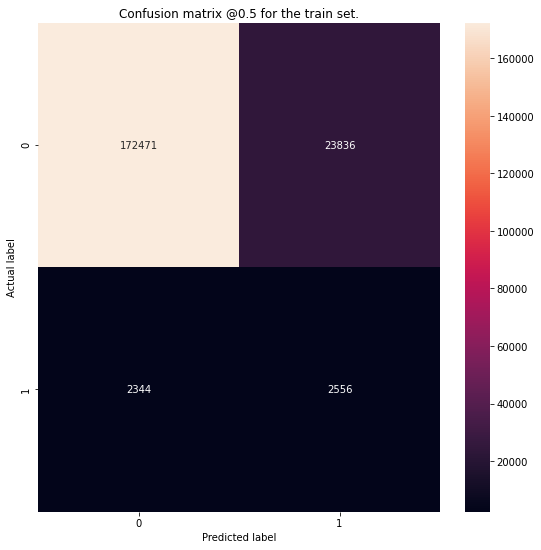


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.6895491165155223
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     84264
           1       0.08      0.51      0.14      1907

    accuracy                           0.86     86171
   macro avg       0.53      0.69      0.53     86171
weighted avg       0.97      0.86      0.91     86171



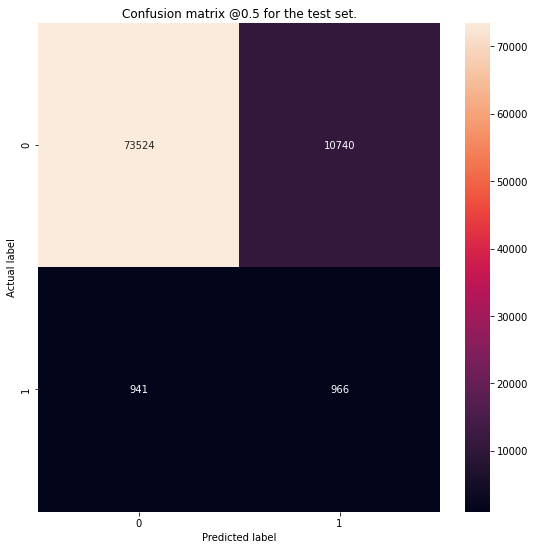

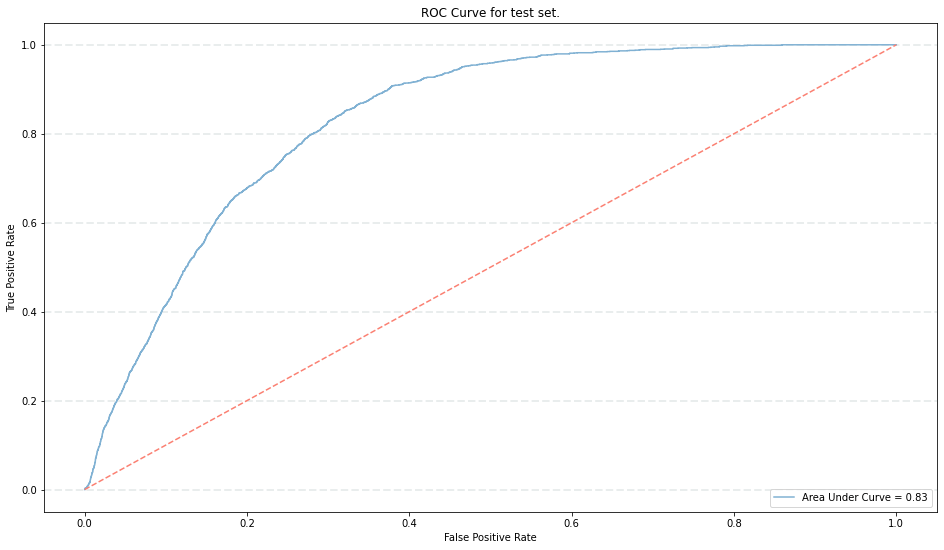










 ============== FRESH_CNN ==============

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.8975215159137973
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    196307
           1       0.14      0.93      0.25      4900

    accuracy                           0.86    201207
   macro avg       0.57      0.90      0.59    201207
weighted avg       0.98      0.86      0.91    201207



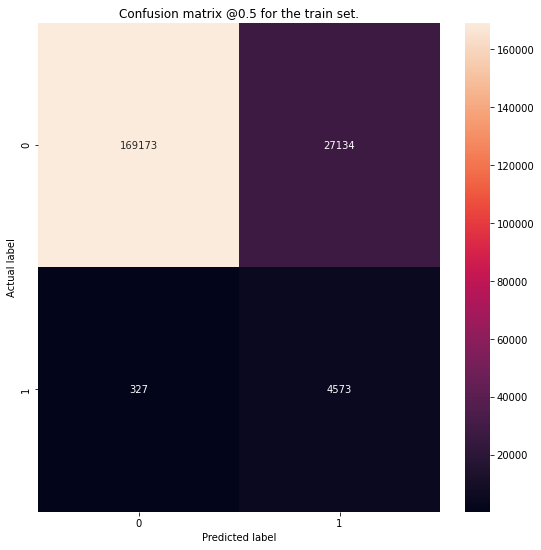

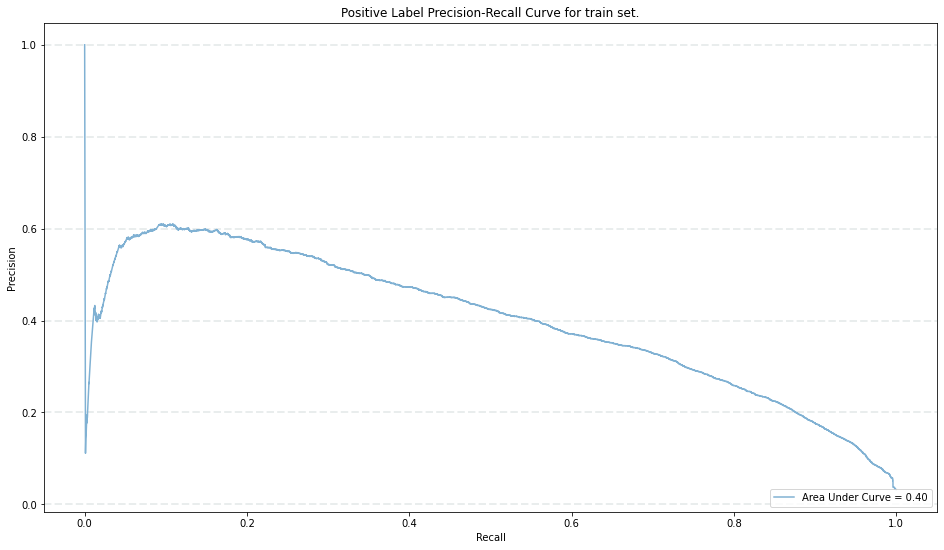


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.8810807156333547
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     84264
           1       0.12      0.91      0.22      1907

    accuracy                           0.86     86171
   macro avg       0.56      0.88      0.57     86171
weighted avg       0.98      0.86      0.91     86171



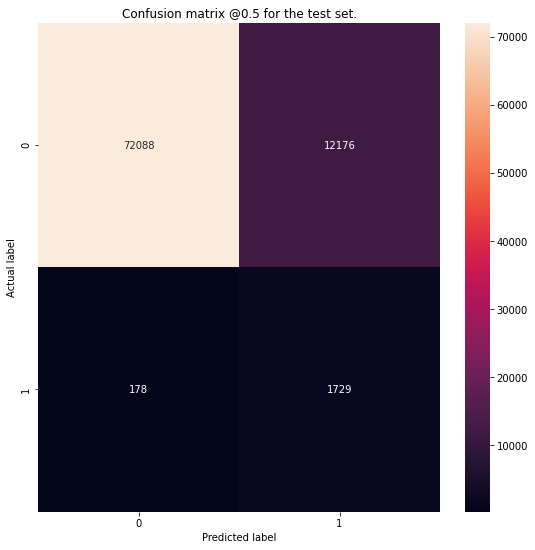

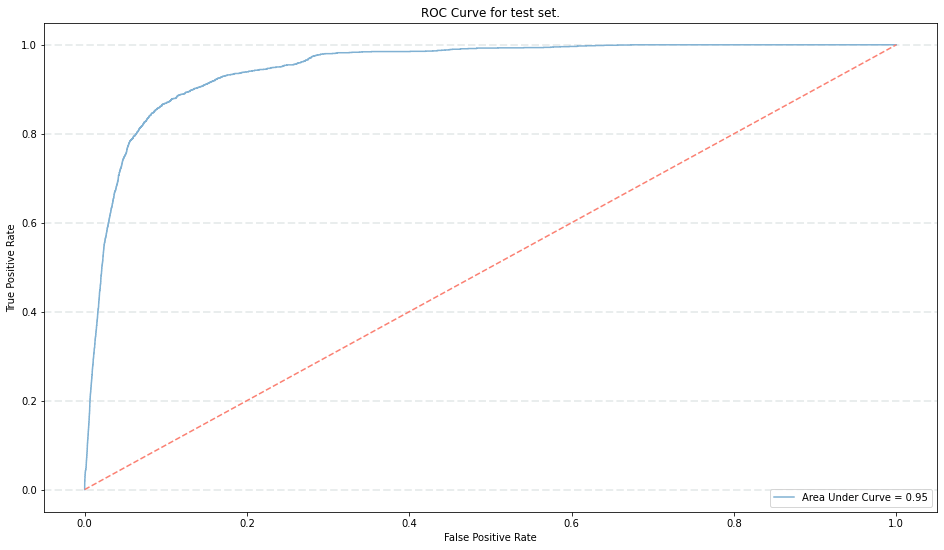










 ============== PCA_CNN ==============

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.6803871081561856
              precision    recall  f1-score   support

           0       0.99      0.52      0.68    196307
           1       0.04      0.84      0.08      4900

    accuracy                           0.53    201207
   macro avg       0.52      0.68      0.38    201207
weighted avg       0.97      0.53      0.67    201207



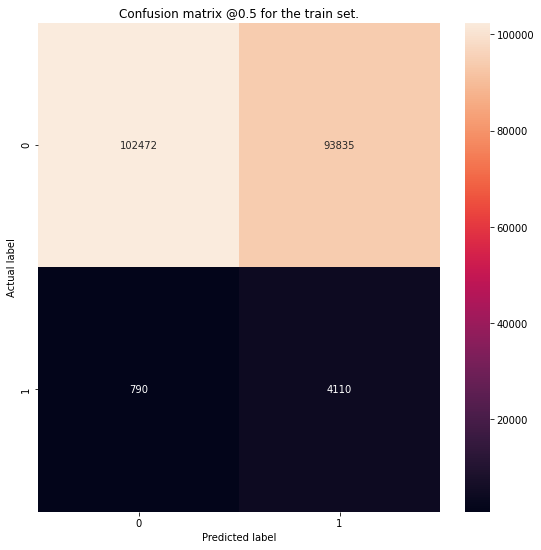

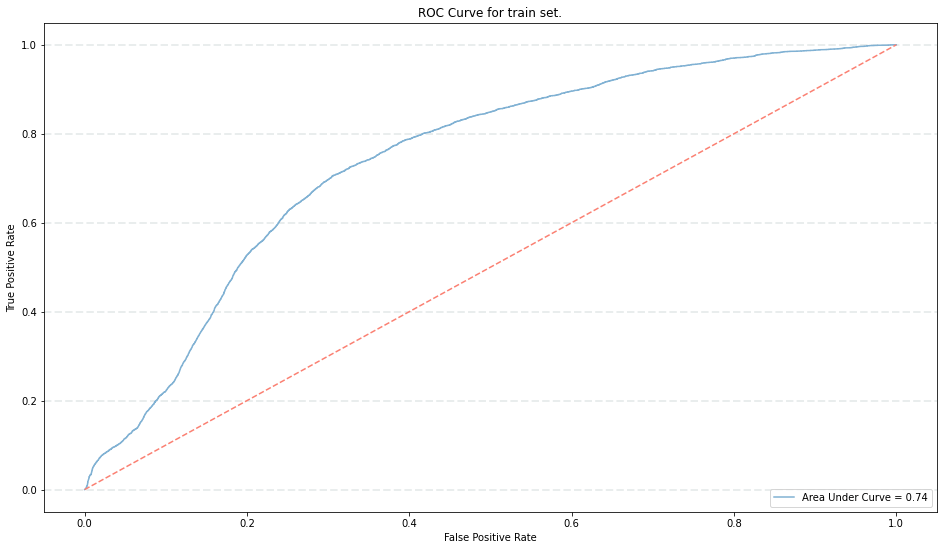


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.6772310558804597
              precision    recall  f1-score   support

           0       0.99      0.53      0.69     84264
           1       0.04      0.83      0.07      1907

    accuracy                           0.53     86171
   macro avg       0.52      0.68      0.38     86171
weighted avg       0.97      0.53      0.68     86171



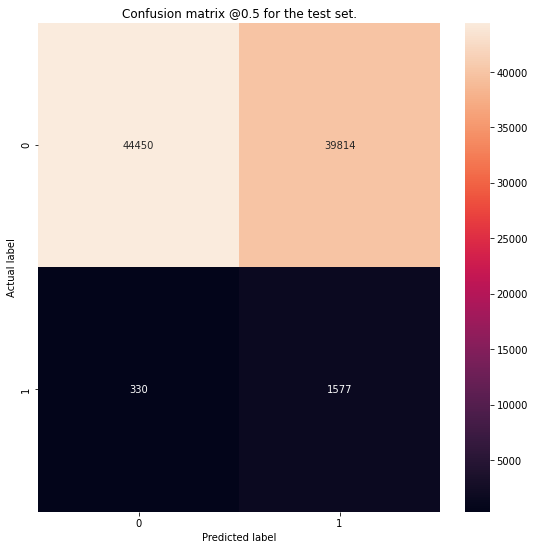

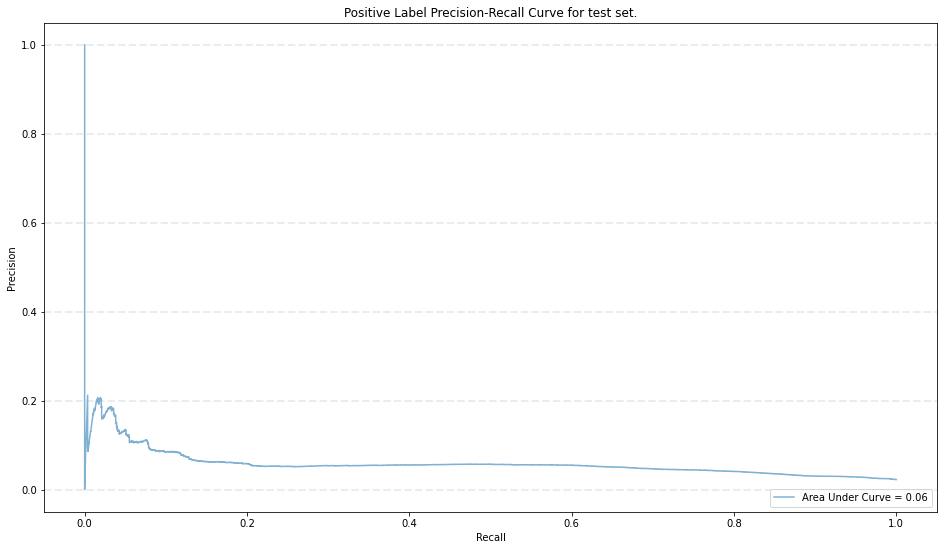

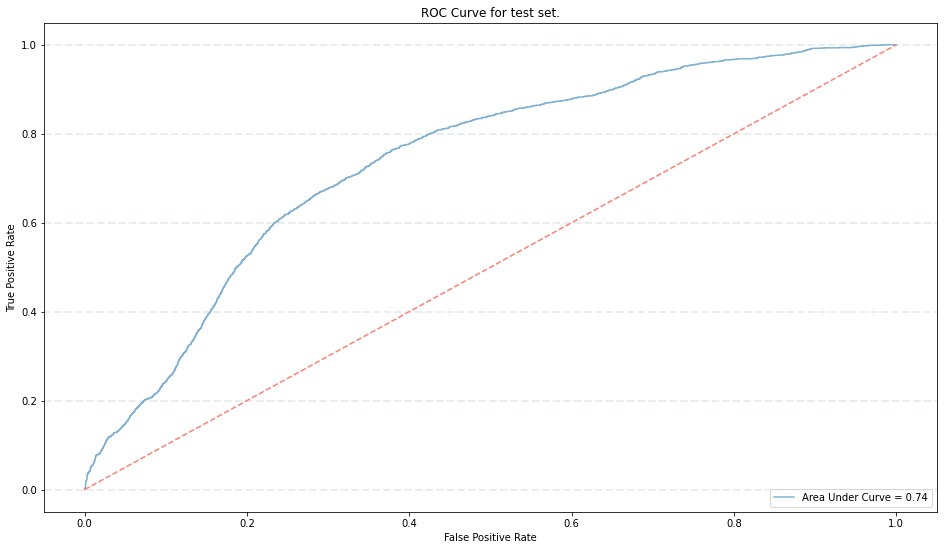










 ============== SIRS_CNN ==============

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.7959750554187147
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    196307
           1       0.16      0.68      0.25      4900

    accuracy                           0.90    201207
   macro avg       0.57      0.80      0.60    201207
weighted avg       0.97      0.90      0.93    201207



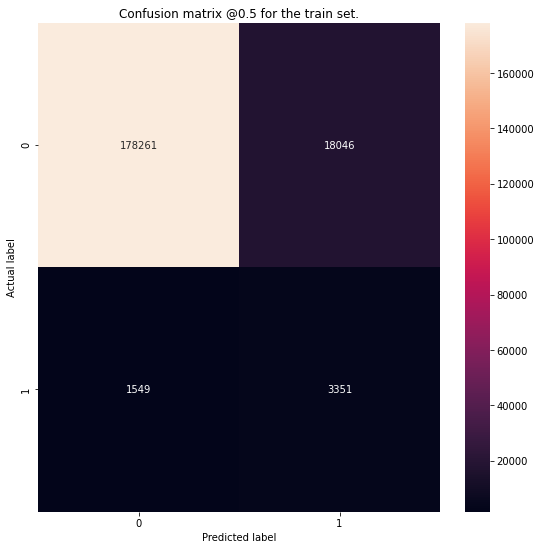

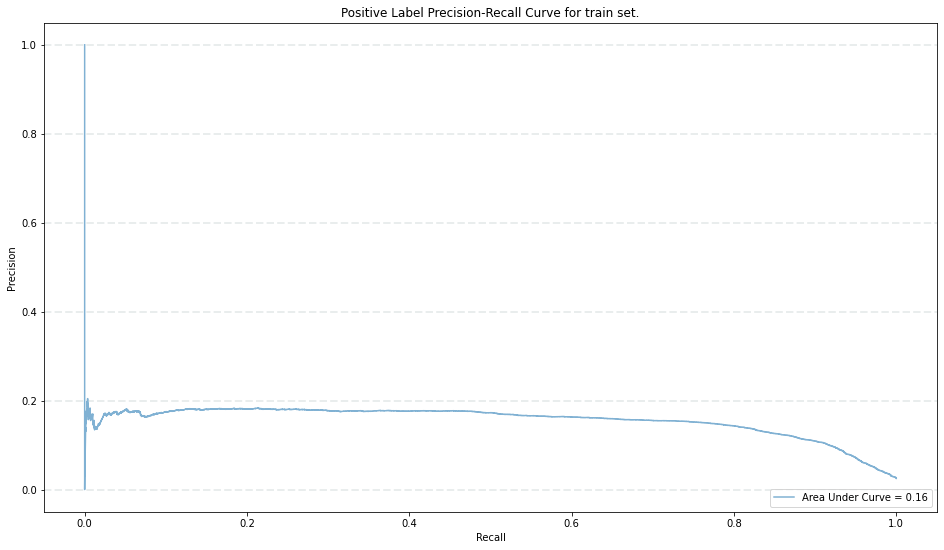

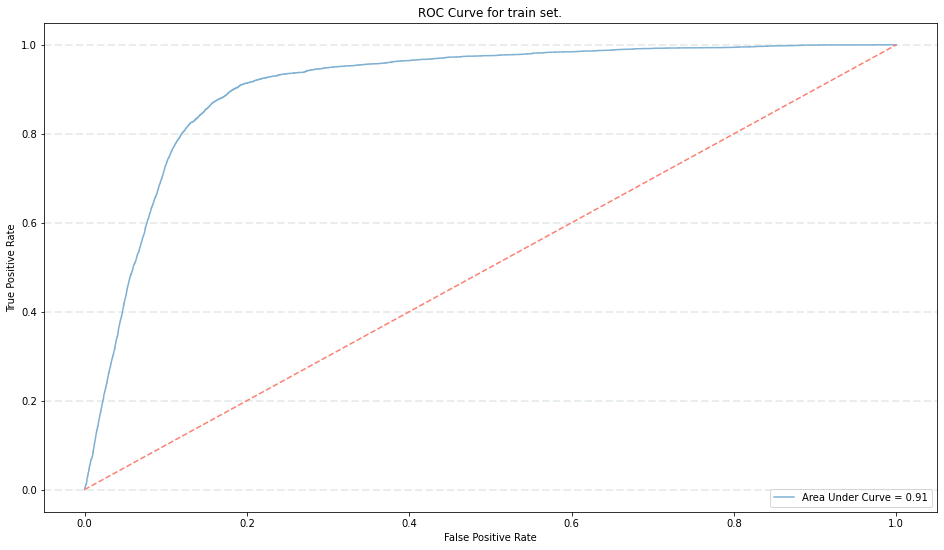


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.7813604305812217
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     84264
           1       0.15      0.65      0.24      1907

    accuracy                           0.91     86171
   macro avg       0.57      0.78      0.59     86171
weighted avg       0.97      0.91      0.94     86171



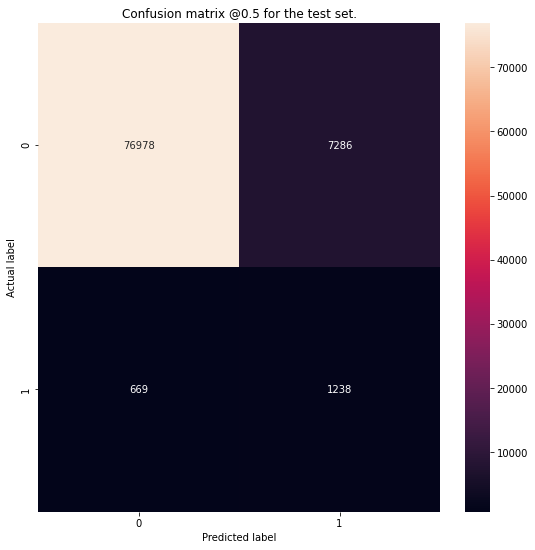

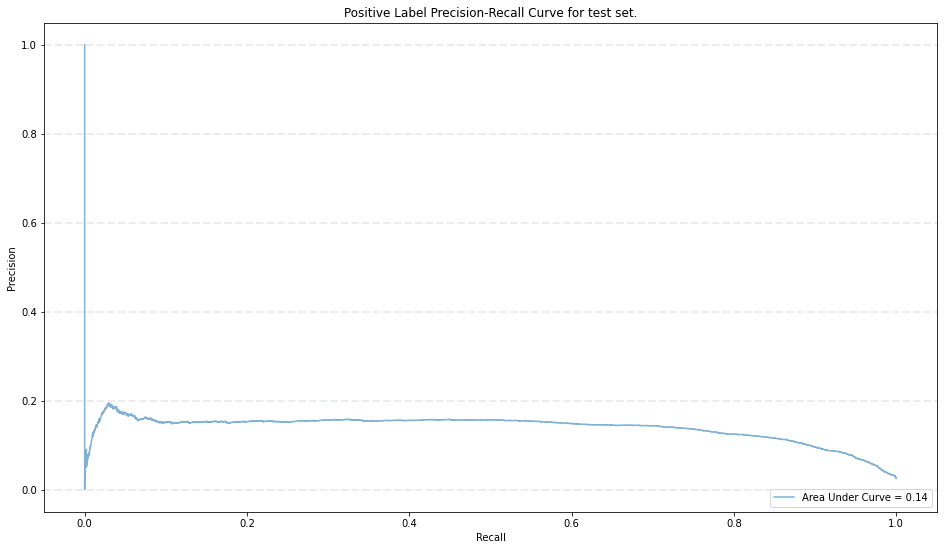

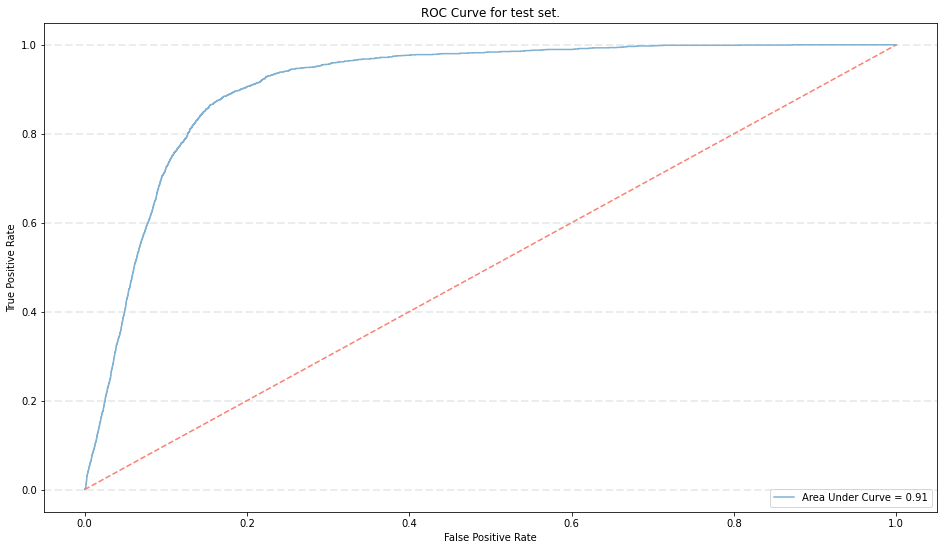










 ============== sparse_CNN ==============

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.9273379576325835
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    196307
           1       0.16      0.99      0.27      4900

    accuracy                           0.87    201207
   macro avg       0.58      0.93      0.60    201207
weighted avg       0.98      0.87      0.91    201207



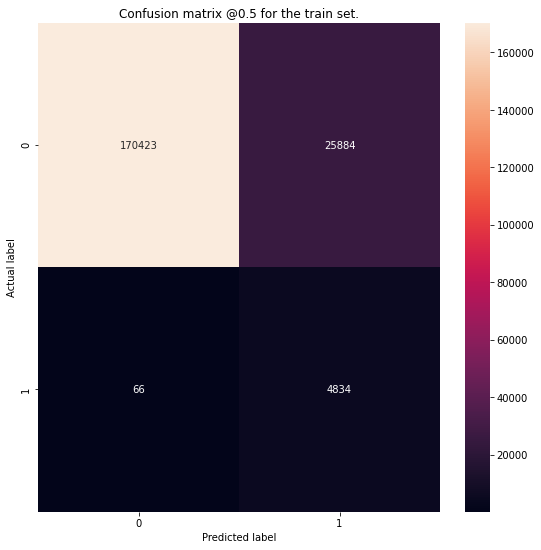

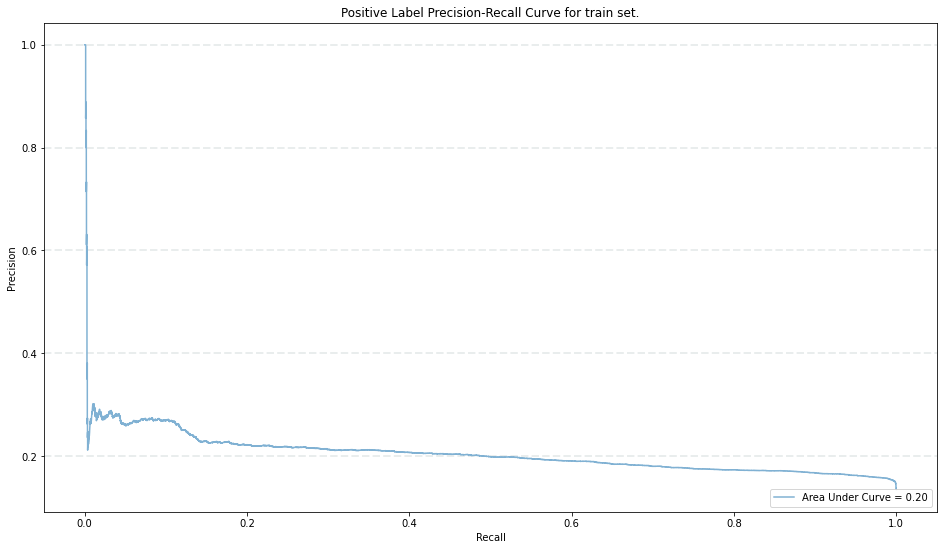

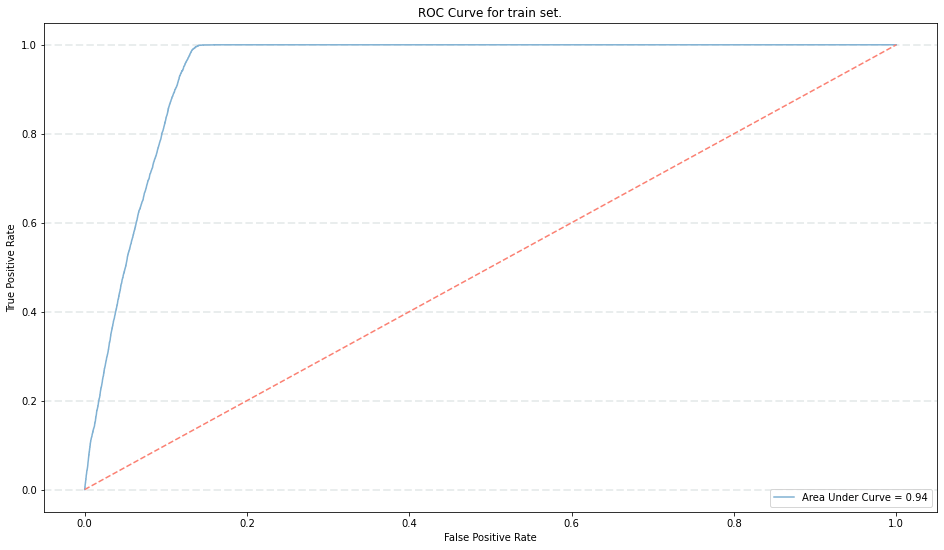


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.9101674813459892
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     84264
           1       0.14      0.95      0.25      1907

    accuracy                           0.87     86171
   macro avg       0.57      0.91      0.59     86171
weighted avg       0.98      0.87      0.92     86171



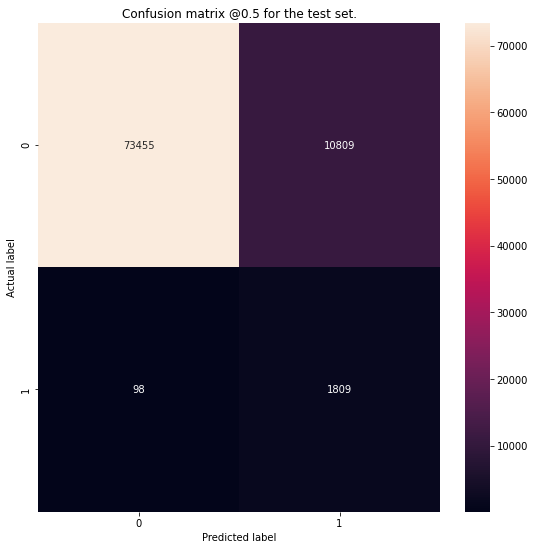

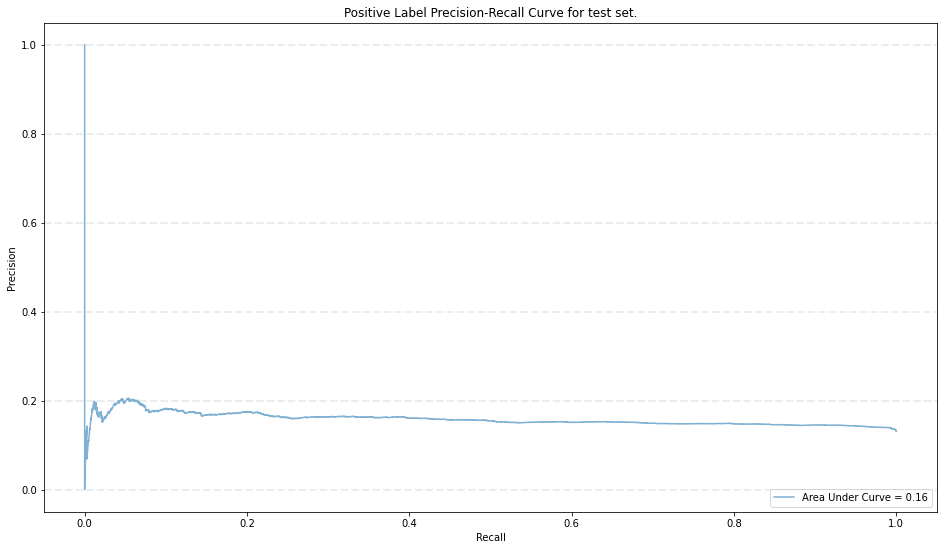

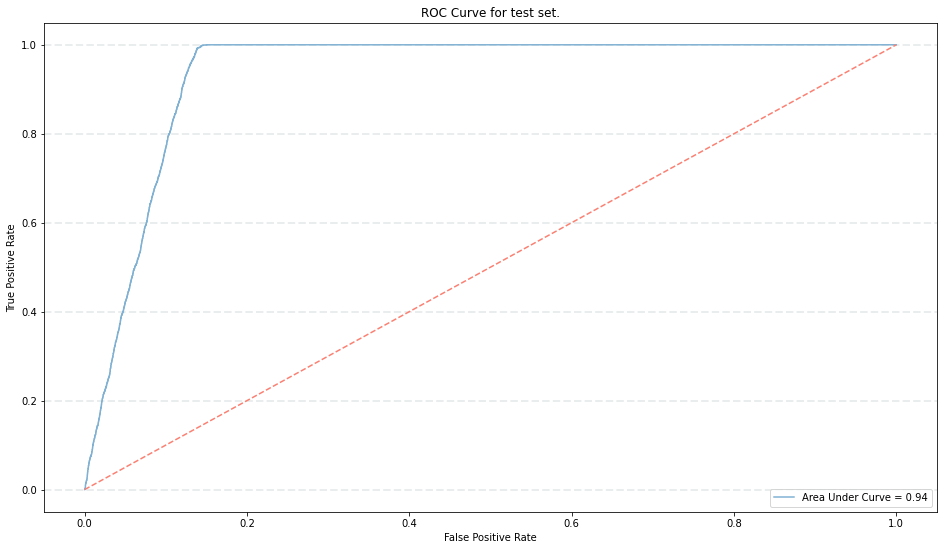

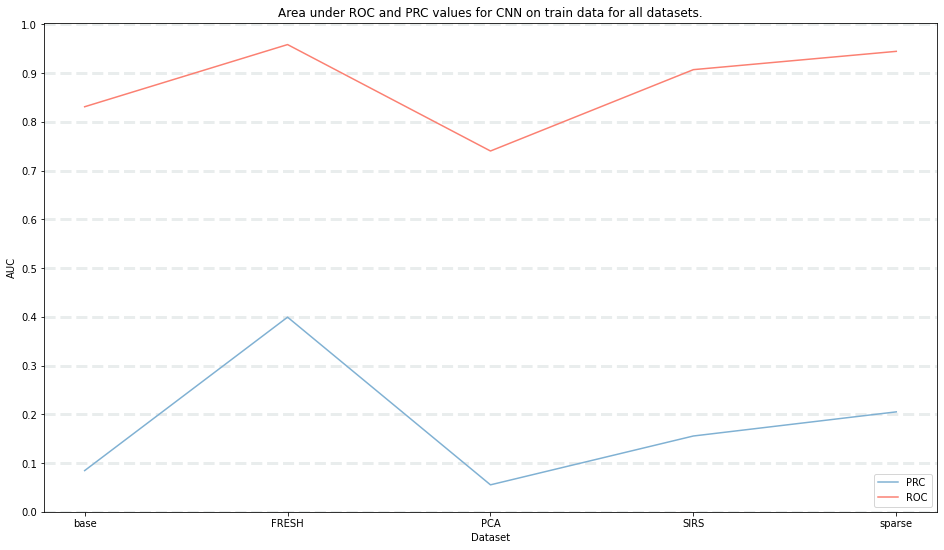

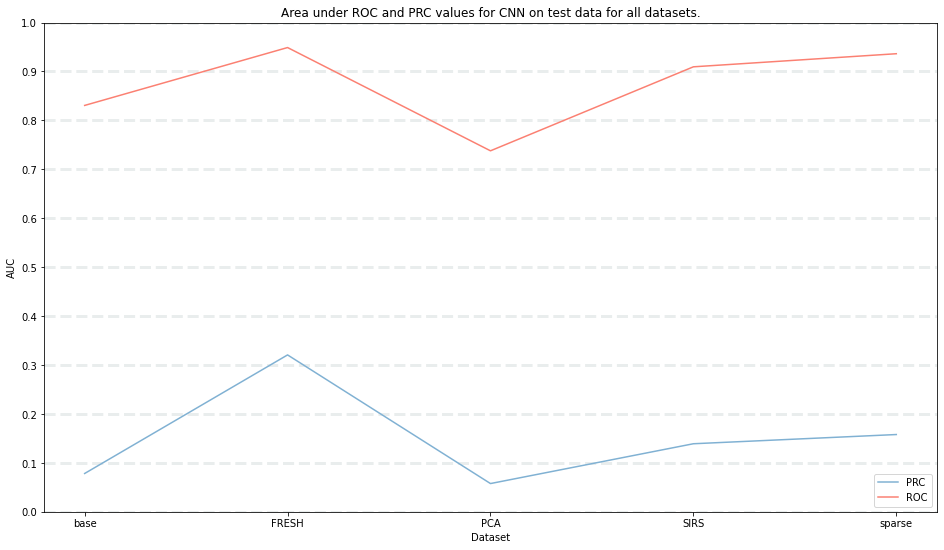

In [17]:
x_train, y_train, x_test, y_test, class_weights = load_dataset_for_conven(truncate_ratio=0.25)
del x_train, x_test, class_weights

# CNN
with open('./deep-results-CNN-25-5-ephocs.pkl', 'rb') as handle:
    conven_models_results = pickle.load(handle)

######### MAKE NEW FIGURES ##########
all_train_pred = []
all_test_pred = []

for key in conven_models_results:
    all_train_pred.append((conven_models_results[key][0]))
    all_test_pred.append(conven_models_results[key][1])

all_PRC_curves(y_test, all_test_pred, 'test', 'CNN')
all_PRC_curves(y_train, all_train_pred, 'train', 'CNN')

plot_AU_across_datasets(y_train, all_train_pred, 'CNN', 'train') 
plot_AU_across_datasets(y_test, all_test_pred, 'CNN', 'test') 

######### FOR TEXT ##########
avgPRC = 0
avgROC = 0
print("\nFOR TEST")
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_test, conven_models_results[key][1])
    avgROC = avgROC+ roc_auc_score(y_test, conven_models_results[key][1])
    get_all_useful(y_test, conven_models_results[key][1])
avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))
print("\n")
print("\n")
print("\n")
print("FOR TRAIN")
avgPRC = 0
avgROC = 0
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_train, conven_models_results[key][0])
    avgROC = avgROC+ roc_auc_score(y_train, conven_models_results[key][0])
    get_all_useful(y_train, conven_models_results[key][0])

avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))

############### OLD ##############

for key in conven_models_results:
    print("\n ============== "+key+" ==============")
    evaluate_conventional(conven_models_results[key][0],conven_models_results[key][1], y_train, y_test)
    print("\n")

#############################

# SNN


FOR TEST
FRESH_SNN
AUC-PRC:0.6268366732403481
AUC-ROC:0.9803677511201467
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     84264
           1       0.29      0.90      0.44      1907

    accuracy                           0.95     86171
   macro avg       0.64      0.92      0.71     86171
weighted avg       0.98      0.95      0.96     86171

base_SNN
AUC-PRC:0.10982764506112391
AUC-ROC:0.8690131163669643
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     84264
           1       0.08      0.85      0.14      1907

    accuracy                           0.77     86171
   macro avg       0.54      0.81      0.50     86171
weighted avg       0.98      0.77      0.85     86171

AVG PRC:0.1473328636602944
AVG ROC:0.3698761734974222






FOR TRAIN
FRESH_SNN
AUC-PRC:0.7235828049723804
AUC-ROC:0.9843629636544924
              precision    recall  f1-score   support

           0       

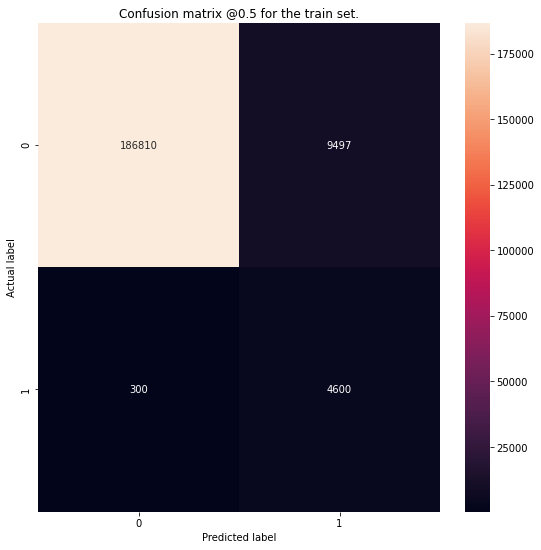

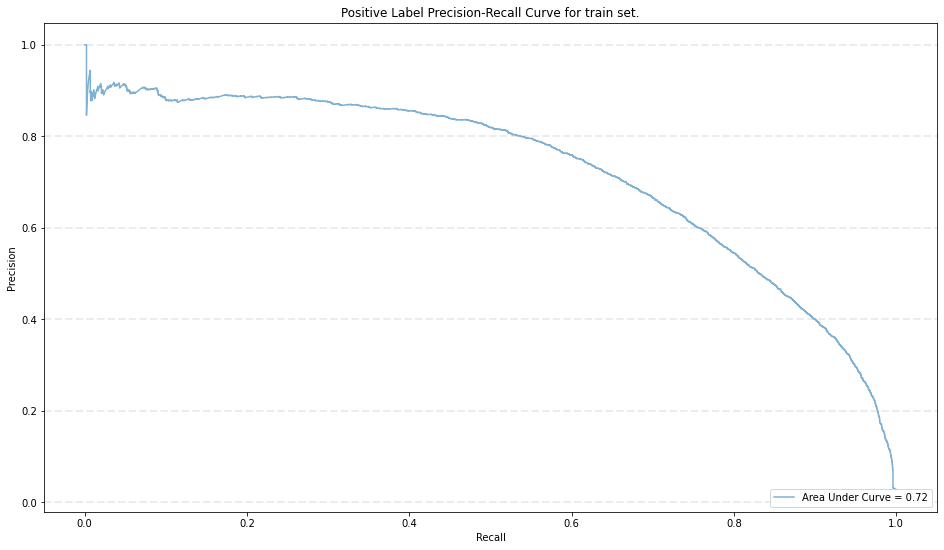

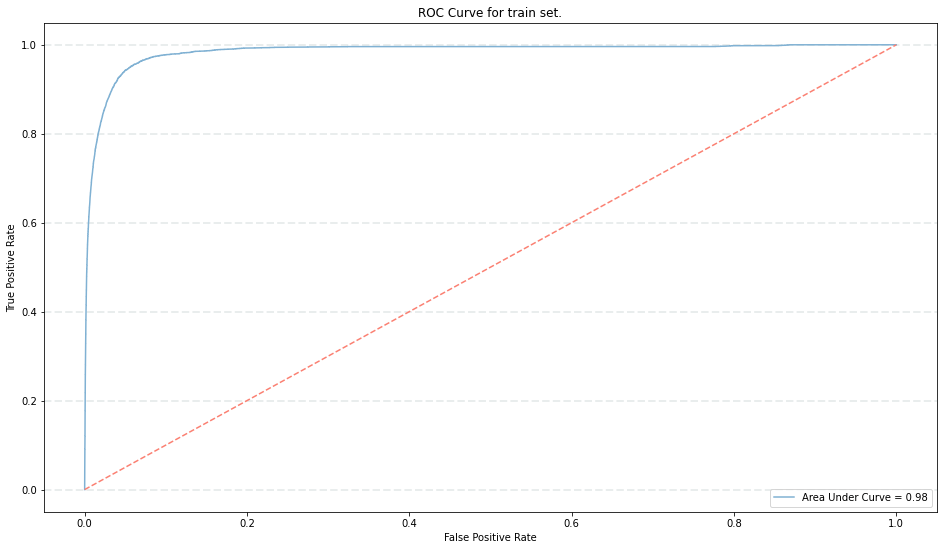


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.9229781630942799
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     84264
           1       0.29      0.90      0.44      1907

    accuracy                           0.95     86171
   macro avg       0.64      0.92      0.71     86171
weighted avg       0.98      0.95      0.96     86171



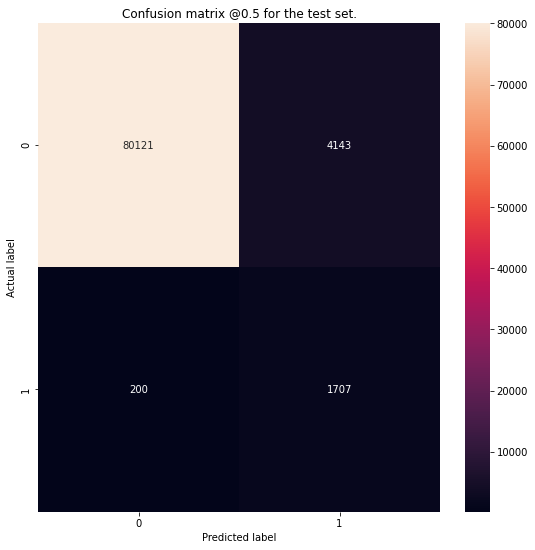

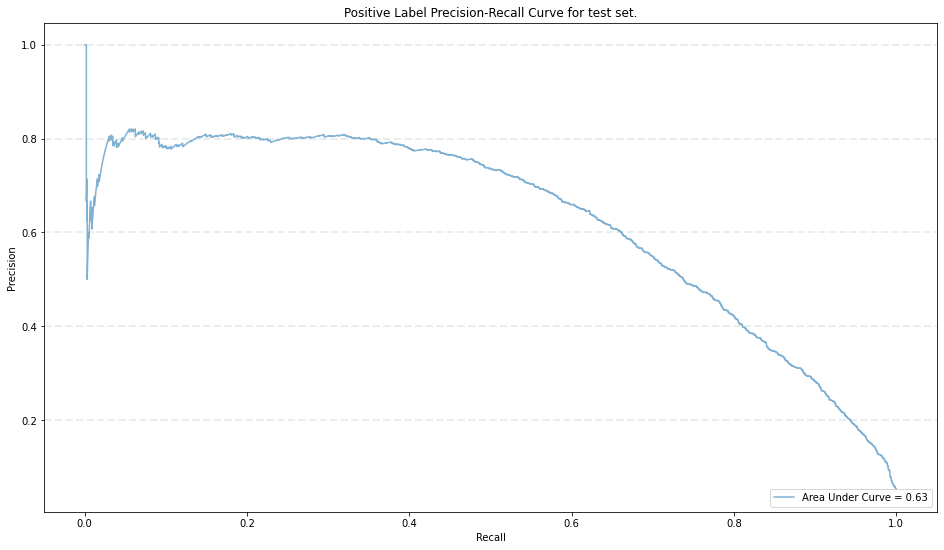

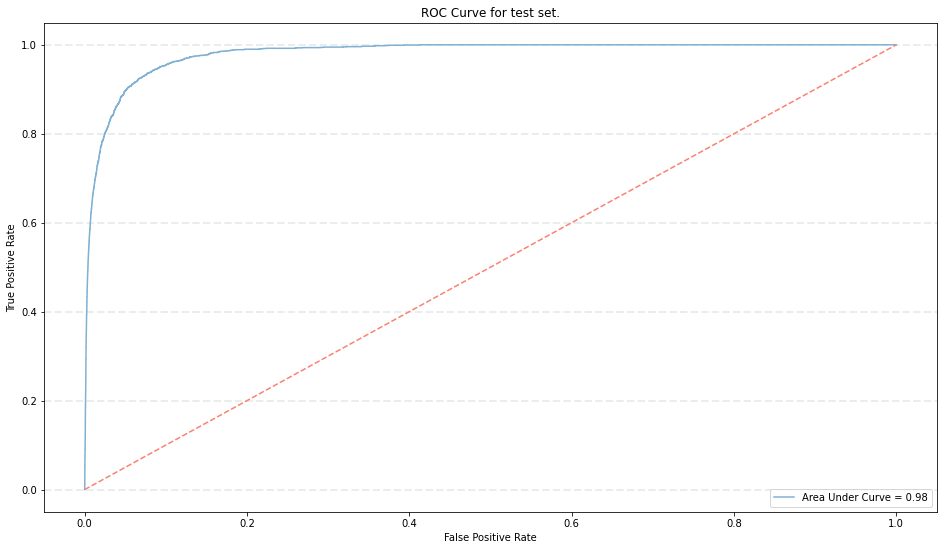








 ============== base_SNN ==============

 ====== Training set Metrics ====== 
Balanced accuracy on training set:  0.8224701116316873
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    196307
           1       0.09      0.87      0.16      4900

    accuracy                           0.77    201207
   macro avg       0.54      0.82      0.51    201207
weighted avg       0.97      0.77      0.85    201207



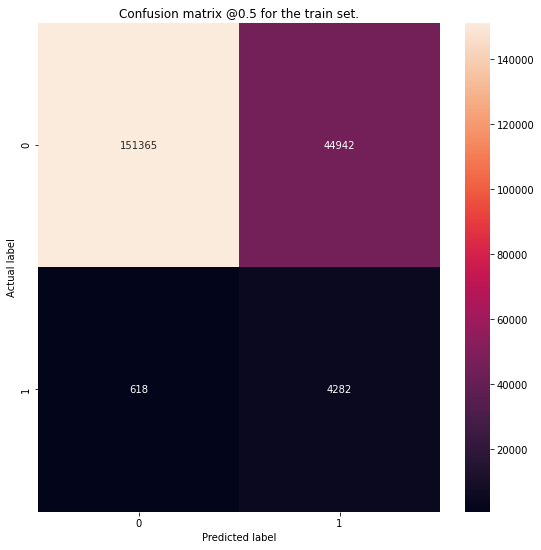

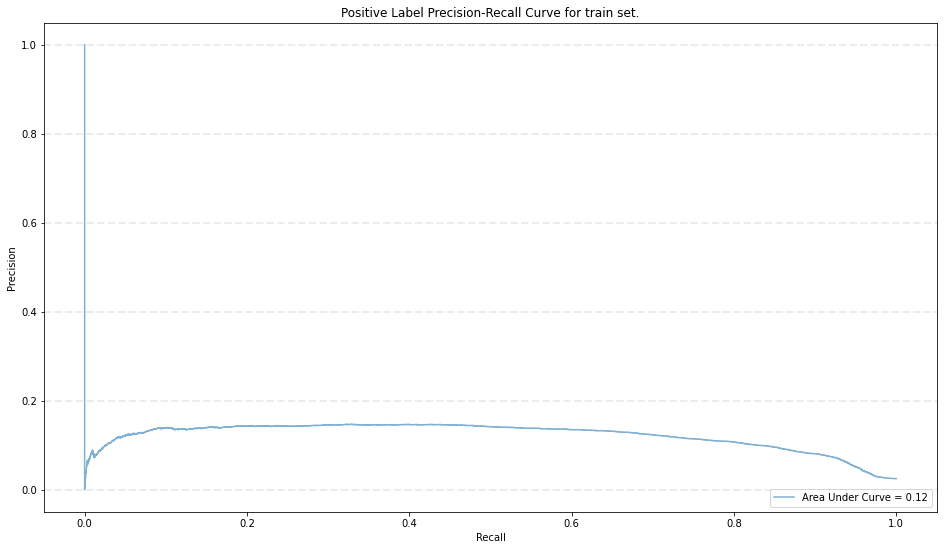

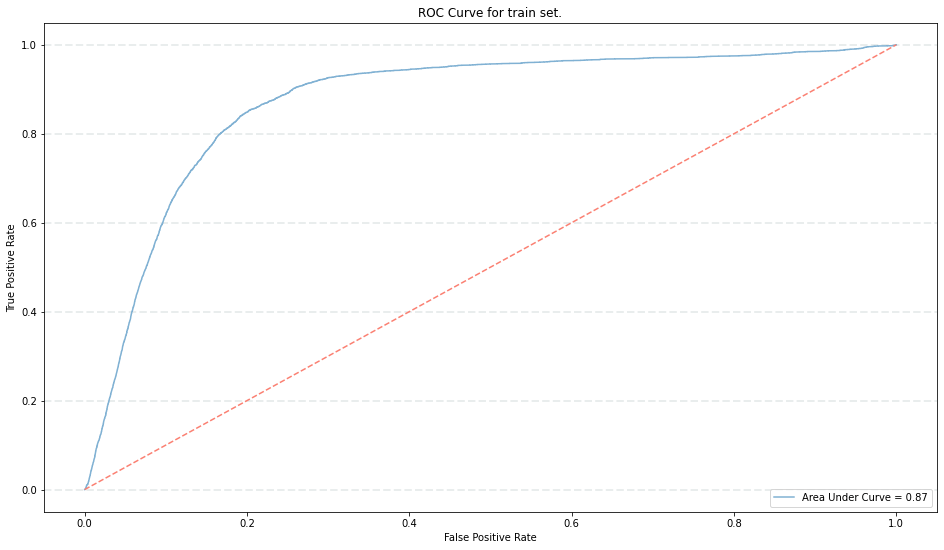


 ====== Test set Metrics: ====== 
Balanced accuracy on test set:  0.8112318989122558
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     84264
           1       0.08      0.85      0.14      1907

    accuracy                           0.77     86171
   macro avg       0.54      0.81      0.50     86171
weighted avg       0.98      0.77      0.85     86171



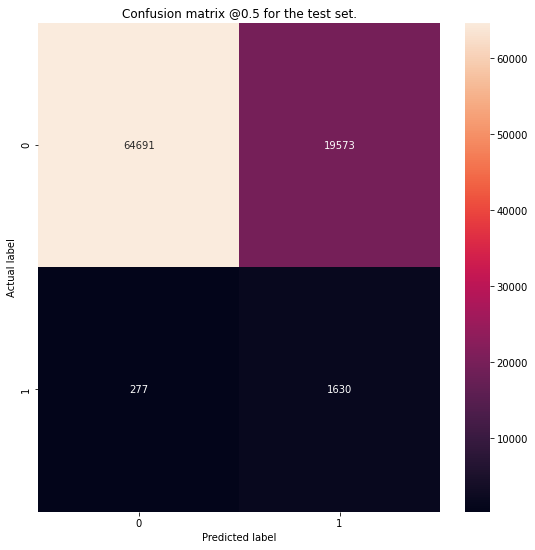

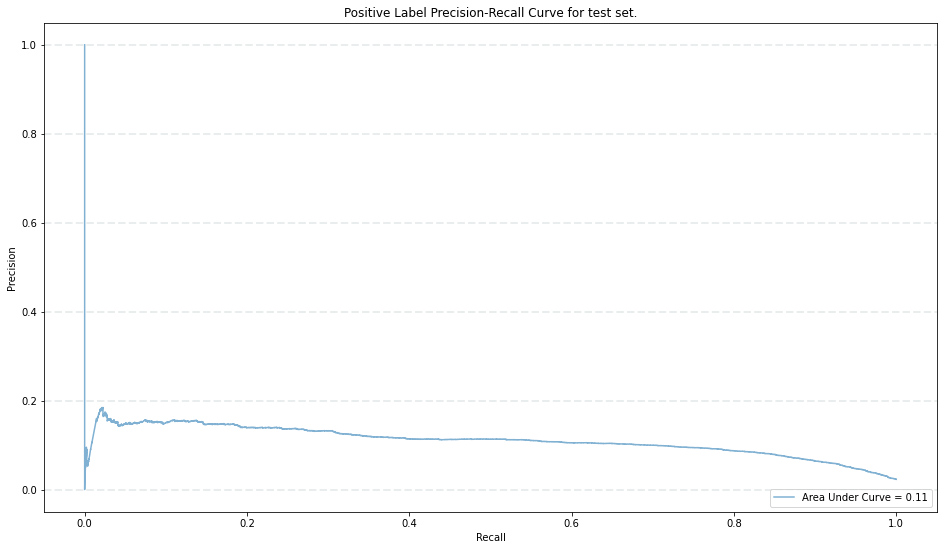

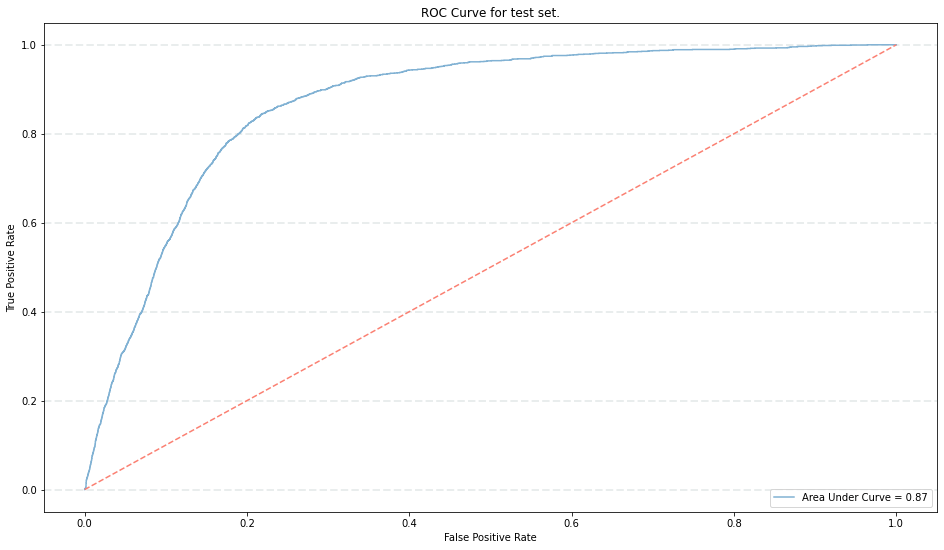

In [110]:

#x_train, y_train, x_test, y_test, class_weights = load_dataset_for_conven(truncate_ratio=0.25)
#del x_train, x_test, class_weights

with open('./deep-results-SNN-25-5-ephocs-all.pkl', 'rb') as handle:
    conven_models_results = pickle.load(handle)

######### MAKE NEW FIGURES ##########
#all_train_pred = []
#all_test_pred = []

#for key in conven_models_results:
#    all_train_pred.append((conven_models_results[key][0]))
#    all_test_pred.append(conven_models_results[key][1])

#all_PRC_curves(y_test, all_test_pred, 'test', 'SNN')
#all_PRC_curves(y_train, all_train_pred, 'train', 'SNN')

#plot_AU_across_datasets(y_train, all_train_pred, 'SNN', 'train') 
#plot_AU_across_datasets(y_test, all_test_pred, 'SNN', 'test') 

######### FOR TEXT ##########

avgPRC = 0
avgROC = 0
print("\nFOR TEST")
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_test, conven_models_results[key][1])
    avgROC = avgROC+ roc_auc_score(y_test, conven_models_results[key][1])
    get_all_useful(y_test, conven_models_results[key][1])
avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))
print("\n")
print("\n")
print("\n")
print("FOR TRAIN")
avgPRC = 0
avgROC = 0
for key in conven_models_results:
    print(key)
    avgPRC = avgPRC+ average_precision_score(y_train, conven_models_results[key][0])
    avgROC = avgROC+ roc_auc_score(y_train, conven_models_results[key][0])
    get_all_useful(y_train, conven_models_results[key][0])

avgPRC = avgPRC/5
avgROC = avgROC/5
print("AVG PRC:"+str(avgPRC))
print("AVG ROC:"+str(avgROC))

############### OLD ##############

for key in conven_models_results:
    print("\n ============== "+key+" ==============")
    evaluate_conventional(conven_models_results[key][0],conven_models_results[key][1], y_train, y_test)
    print("\n")

#############################

# Rough Implementations for Aggregate Result Functions

In [80]:
# more helpers
def plot_ROC_across_datasets_for_all(labels, predictions, dataset_type, svm_preds):
  dataset_list = ['base', 'FRESH', 'PCA', 'SIRS', 'sparse']
  model_list = ['LR', 'CNN', 'SNN']
  AUROC = []
  plt.figure(figsize=(16, 9))
  for j in range(len(model_list)):
    AUROC = []
    for i in range(len(dataset_list)):
      AUROC.append(roc_auc_score(labels, predictions[j][i]))
    plt.plot(dataset_list, AUROC, color=colours[j], label=model_list[j], linewidth=2)
  # do svm seperately as it used less data
  AUROC = []
  for l in range(len(dataset_list)):
      AUROC.append(roc_auc_score(labels[:len(svm_preds[0])], svm_preds[l]))
  plt.plot(dataset_list, AUROC, color=colours[j+2], label='SVM', linewidth=2)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='y', alpha=0.2)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='x', alpha=0.2)
  plt.yticks(np.arange(0.5, 1.1, 0.05))
  plt.xlabel('Dataset')
  plt.ylabel('AUROC')
  plt.title('ROC values for all models on all '+dataset_type+' datasests.')
  plt.legend(loc="lower right")
  plt.savefig('./sepsis-detection/notebooks/Notebook 7 - Model training and evaluative results/figures/''all_'+str(dataset_type) +'_AUROC.jpg')
  plt.show()

def plot_PRC_across_datasets_for_all(labels, predictions, dataset_type, svm_preds):
  dataset_list = ['base', 'FRESH', 'PCA', 'SIRS', 'sparse']
  model_list = ['LR', 'CNN', 'SNN']
  AUPRC = []
  plt.figure(figsize=(16, 9))
  for j in range(len(model_list)):
    AUPRC = []
    for i in range(len(dataset_list)):
      AUPRC.append(average_precision_score(labels, predictions[j][i]))
    plt.plot(dataset_list, AUPRC, color=colours[j], label=model_list[j], linewidth=2)
  # do svm seperately as it used less data
  AUPRC = []
  for l in range(len(dataset_list)):
      AUPRC.append(average_precision_score(labels[:len(svm_preds[0])], svm_preds[l]))
  plt.plot(dataset_list, AUPRC, color=colours[j+2], label='SVM', linewidth=2)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='y', alpha=0.2)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='x', alpha=0.2)
  plt.yticks(np.arange(0, 0.8, 0.05))
  plt.xlabel('Dataset')
  plt.ylabel('AUPRC')
  plt.title('PRC values for all models on all '+dataset_type+' datasests.')
  plt.legend(loc="lower right")
  plt.savefig('./sepsis-detection/notebooks/Notebook 7 - Model training and evaluative results/figures/''all_'+str(dataset_type) +'_AUPRCs.jpg')
  plt.show()

def all_datasets_prc(labels, predictions, dataset_type, svm_preds):
  dataset_list = ['base', 'FRESH', 'PCA', 'SIRS', 'sparse']
  model_list = ['LR', 'CNN', 'SNN']
  plt.figure(figsize=(16, 9))
  avg_PRC_List = []
  for j in range(len(dataset_list)):
    avgPRC = average_precision_score(labels[:len(svm_preds[0])], svm_preds[j])
    for i in range(len(model_list)):
      avgPRC += (average_precision_score(labels, predictions[i][j]))
    avg_PRC_List.append(avgPRC/4)
    print("Average AUPRC for "+str(dataset_list[j])+": "+str(avgPRC/4))
  plt.plot(dataset_list, avg_PRC_List, color=colours[1], label='AVG PRC for all models', linewidth=2)       
  plt.plot(dataset_list, [ (sum(avg_PRC_List) / len(avg_PRC_List)) for _ in range(len(avg_PRC_List))], color=colours[0], label='Average Perfromance: '+str(((sum(avg_PRC_List) / len(avg_PRC_List))))[:4], linewidth=4, alpha=0.5)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='y', alpha=0.2)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='x', alpha=0.2)
  plt.yticks(np.arange(0, 0.55, 0.05))
  plt.xlabel('Dataset')
  plt.ylabel('AUPRC')
  plt.title('Averaged model AUPRC across all '+dataset_type+' datasests.')
  plt.legend(loc="lower right")
  plt.savefig('./sepsis-detection/notebooks/Notebook 7 - Model training and evaluative results/figures/''average_'+str(dataset_type) +'_AUPRC_across_datasets.jpg')
  plt.show()

def all_datasets_roc(labels, predictions, dataset_type, svm_preds):
  dataset_list = ['base', 'FRESH', 'PCA', 'SIRS', 'sparse']
  model_list = ['LR', 'CNN', 'SNN']
  plt.figure(figsize=(16, 9))
  avg_PRC_List = []
  for j in range(len(dataset_list)):
    # add svm
    avgPRC = roc_auc_score(labels[:len(svm_preds[0])], svm_preds[j])
    for i in range(len(model_list)):
      avgPRC += (roc_auc_score(labels, predictions[i][j]))
    avg_PRC_List.append(avgPRC/4)
    print("Average AUROC for "+str(dataset_list[j])+": "+str(avgPRC/4))
  plt.plot(dataset_list, avg_PRC_List, color=colours[1], label='AVG ROC for all models', linewidth=2)       
  plt.plot(dataset_list, [ (sum(avg_PRC_List) / len(avg_PRC_List)) for _ in range(len(avg_PRC_List))], color=colours[0], label='Average Perfromance: '+str(((sum(avg_PRC_List) / len(avg_PRC_List))))[:4], linewidth=4, alpha=0.5)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='y', alpha=0.2)
  plt.grid(color='#95a5a6', linestyle='--', linewidth=3, axis='x', alpha=0.2)
  plt.yticks(np.arange(0.5, 1.1, 0.05))
  plt.xlabel('Dataset')
  plt.ylabel('AUROC')
  plt.title('Averaged model AUROC across all '+dataset_type+' datasests.')
  plt.legend(loc="lower right")
  plt.savefig('./sepsis-detection/notebooks/Notebook 7 - Model training and evaluative results/figures/''average_'+str(dataset_type) +'_AUROC_across_datasets.jpg')
  plt.show()